In [4]:
# import all the required libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow. keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [5]:
# Paths
dataset_path = "./intel-image-classification-dataset/" 
train_path = os.path.join(dataset_path, "seg_train")  # Folder containing train images
train_path
test_path = os.path.join(dataset_path, "seg_test")    # Folder containing test images

In [6]:
# Filter classes (forest and mountain only)
classes = ['forest', 'mountain']


In [7]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    classes=classes
)
test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    classes=classes,
    shuffle=False
)

Found 4783 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


In [8]:
# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Training
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/10
150/150 [==============================] - 96s 634ms/step - loss: 0.2127 - accuracy: 0.9239 - val_loss: 0.0693 - val_accuracy: 0.9830
Epoch 2/10
150/150 [==============================] - 93s 621ms/step - loss: 0.1235 - accuracy: 0.9624 - val_loss: 0.0552 - val_accuracy: 0.9850
Epoch 3/10
150/150 [==============================] - 95s 634ms/step - loss: 0.1003 - accuracy: 0.9707 - val_loss: 0.0555 - val_accuracy: 0.9860
Epoch 4/10
150/150 [==============================] - 105s 696ms/step - loss: 0.0989 - accuracy: 0.9709 - val_loss: 0.0450 - val_accuracy: 0.9890
Epoch 5/10
150/150 [==============================] - 205s 1s/step - loss: 0.0804 - accuracy: 0.9766 - val_loss: 0.0368 - val_accuracy: 0.9890
Epoch 6/10
150/150 [==============================] - 198s 1s/step - loss: 0.0798 - accuracy: 0.9760 - val_loss: 0.0377 - val_accuracy: 0.9910
Epoch 7/10
150/150 [==============================] - 184s 1s/step - loss: 0.0784 - accuracy: 0.9751 - val_loss: 0.0457 - val_accurac

In [10]:
# Evaluation
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

32/32 [==============================] - 4s 125ms/step - loss: 0.0413 - accuracy: 0.9890
Test Accuracy: 98.90%


In [11]:
# Predictions
predictions = (model.predict(test_data) > 0.5).astype("int32")
true_labels = test_data.classes
print(classification_report(true_labels, predictions, target_names=classes))

32/32 [==============================] - 4s 125ms/step
              precision    recall  f1-score   support

      forest       0.99      0.99      0.99       474
    mountain       0.99      0.99      0.99       525

    accuracy                           0.99       999
   macro avg       0.99      0.99      0.99       999
weighted avg       0.99      0.99      0.99       999



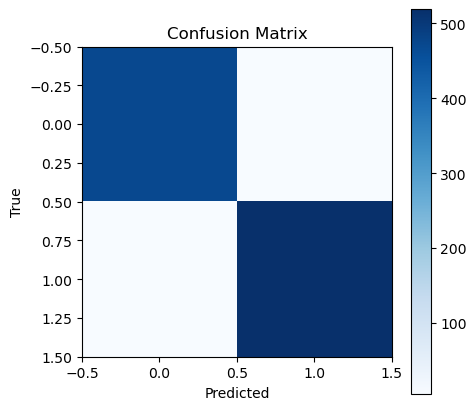

In [12]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
# Save Model
model.save('forest_vs_mountain_classifier.h5')

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Image dimensions and batch size
IMG_SIZE = 128
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load the MobileNetV2 model with pre-trained weights (excluding the top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create the model with custom top layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(valid_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')
